In [23]:
"""

Code Description:
This scropit reads the cs100 results for faults that have realization with both bulldozed and squashed-tapered topography representation
and compare the results.


Author: Morteza
Version History:
- Version 1.0: August 12, 2025

To Do:


"""

'\n\nCode Description:\nThis scropit reads the cs100 results for faults that have realization with both bulldozed and squashed-tapered topography representation\nand compare the results.\n\n\nAuthor: Morteza\nVersion History:\n- Version 1.0: August 12, 2025\n\nTo Do:\n\n\n'

# Import the dependencies

In [24]:
import os
import sys
from pathlib import Path
from typing import Tuple, Union, NamedTuple, Sequence, Dict, Any
import copy
import pickle
import tempfile

import pandas as pd
import numpy as np
import geopandas
import pygmt
from shapely import geometry, Point, Polygon
import xarray as xr
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy.spatial import Delaunay

sys.path.append(str(Path.cwd().parent))
from utils import util
# import seismic_hazard_analysis as sha
import utils.seismic_hazard_analysis.seismic_hazard_analysis as sha
from qcore import nhm
from qcore import coordinates as coords
from pygmt_helper import plotting

# Path and directory works

In [25]:
file_path = Path.cwd()
root_path = file_path.parent.parent  # dpath to root of the project

sim_dir = root_path / "Cybershake_Data" # dpath to simulation data
combined_sim_dir = sim_dir /"combined_cs100"
base_dir = root_path / "cybershake_investigation/base_data" # dpath to dirctory of base data
map_data_ffp = Path("/home/mab419/git_clone/qcore/qcore/data/") # path to qcore/qcore/data

fault_erf_ffp = base_dir / "NZ_FLTmodel_2010.txt" #dpath to NZ fault model
background_ffp = base_dir / "NZBCK211_OpenSHA.txt" # dpath to background seismicity
station_files = {
    "stations_ll": "non_uniform_whole_nz_with_real_stations-hh400_v20p3_land.ll",
    "stations_vs30": "non_uniform_whole_nz_with_real_stations-hh400_v20p3_land.vs30",
    "stations_z": "non_uniform_whole_nz_with_real_stations-hh400_v20p3_land.z",
}

plot_dir = root_path / "cybershake_investigation/plots/topo_type_investigation"  # dpath to directory for plots
plot_dir.mkdir(parents=True, exist_ok=True)  # create the directory if it does not exist

In [26]:
root_path


PosixPath('/mnt/mantle_data/mab419/cs100')

# Define Global Functions

In [27]:
def convert_im(im):
    if im.startswith("pSA"):
        number = im.split("_")[1]
        im_str = f"pSA({number} s) [g]"
    elif im == "PGV":
        im_str = "PGV (cm/s)"
    elif im == "PGD":
        im_str = "PGD (cm)"
    elif im == "PGA":
        im_str = "PGA (g)"
    elif im == "CAV":
        im_str = "CAV"
    elif im == "AI":
        im_str = "AI"
    elif im == "Ds575":
        im_str = "D$_5-75$ s"
    elif im == "Ds595":
        im_str = "D$_5-95$ s"
    return im_str

In [28]:
import math
import numpy as np

def nice_colorbar_limits(vmin, vmax, *, symmetric=False, target_ticks=None,
                         allowed_ticks=(5, 6, 7, 8, 9, 10)):
    """
    Return (vmin_nice, vmax_nice, step, ticks) with pleasant limits.
    - Steps use mantissas in {1, 1.5, 2, 2.5, 5} * 10^k
    - If symmetric=True: odd tick counts only and 0 is in ticks
    - If target_ticks=None: choose among allowed_ticks with strong bias
      against intervals=7 or 9 to avoid '...0.70' or '...0.07' endings.
    """
    vmin, vmax = float(min(vmin, vmax)), float(max(vmin, vmax))
    if not np.isfinite(vmin) or not np.isfinite(vmax) or vmin == vmax:
        # trivial fallback
        center = 0.0 if not np.isfinite(vmin) else float(vmin)
        step = 0.5
        vmin_n, vmax_n = center - 1.0, center + 1.0
        ticks = np.arange(vmin_n, vmax_n + 1e-12, step)
        return vmin_n, vmax_n, step, ticks

    # Allowed step mantissas; note 1.5 is intentionally favored
    mantissas = [1, 1.5, 2, 2.5, 5]
    mantissa_rank = {1.5: 0, 1: 1, 2: 2, 2.5: 3, 5: 4}  # prefer 1.5 over 1

    # Tick candidates
    if target_ticks is None:
        ticks_cand = list(allowed_ticks)
    else:
        if target_ticks not in allowed_ticks:
            raise ValueError(f"target_ticks must be in {allowed_ticks}")
        ticks_cand = [target_ticks]

    # For symmetric scales, only odd tick counts (to include 0 at center)
    if symmetric:
        ticks_cand = [t for t in ticks_cand if t % 2 == 1]
        if not ticks_cand:
            raise ValueError("For symmetric=True, allowed/target ticks must be odd (e.g., 5,7,9).")

    # Penalty for awkward interval counts (avoid 7 or 9)
    # intervals = ticks - 1
    interval_penalty = {4: 1, 5: 0, 6: 0, 7: 3, 8: 0, 9: 3}

    def ceil_step(x):
        """Ceil x to the next allowed nice step."""
        if x <= 0:
            return 0.0
        exp = math.floor(math.log10(x))
        while True:
            for m in mantissas:
                s = m * (10 ** exp)
                if s >= x - 1e-15:
                    return s
            exp += 1

    best = None
    for t in ticks_cand:
        intervals = t - 1

        if symmetric:
            # half intervals on each side of 0
            half = intervals // 2
            req_step = max(abs(vmin), abs(vmax)) / half
            step = ceil_step(req_step)
            vmax_n = step * half
            vmin_n = -vmax_n
            # exact ticks with the chosen count
            ticks = np.linspace(vmin_n, vmax_n, t)
        else:
            # anchor vmin to a multiple of step and ensure EXACT tick count
            span = vmax - vmin
            step = ceil_step(span / intervals)

            # iterate once or twice to ensure coverage when vmin floors down
            for _ in range(3):
                vmin_n = math.floor(vmin / step) * step
                req_step = (vmax - vmin_n) / intervals
                new_step = ceil_step(req_step)
                if new_step == step:
                    break
                step = new_step
            vmin_n = math.floor(vmin / step) * step
            vmax_n = vmin_n + intervals * step
            ticks = vmin_n + step * np.arange(t)

        # scores: (interval awkwardness, overhang, mantissa preference, smaller range)
        overhang = (vmax_n - vmin_n) - (vmax - vmin)
        # mantissa extracted from step
        exp = math.floor(math.log10(step)) if step > 0 else 0
        mant = round(step / (10 ** exp), 10)
        # snap mant to one of our mantissas to index rank safely
        mant = min(mantissas, key=lambda m: abs(m - mant))

        score = (
            interval_penalty.get(intervals, 2),
            overhang,
            mantissa_rank[mant],
            (vmax_n - vmin_n)
        )

        if (best is None) or (score < best[0]):
            best = (score, vmin_n, vmax_n, step, ticks)

    _, vmin_n, vmax_n, step, ticks = best

    # Clean float noise for pretty printing
    def clean(x):
        return float(np.format_float_positional(x, trim='-'))
    vmin_n, vmax_n, step = map(clean, (vmin_n, vmax_n, step))
    ticks = np.array([clean(v) for v in ticks])
    
    # -------- pretty rounding based on step --------
    exp = math.floor(math.log10(step)) if step > 0 else 0
    mant = round(step / (10 ** exp), 10)  # e.g., 1, 1.5, 2, 2.5, 5
    # For our allowed mantissas: 1,2,5 need 0 extra decimals; 1.5,2.5 need 1
    mant_decimals = 0 if mant in (1.0, 2.0, 5.0) else 1
    decimals = max(0, -exp) + mant_decimals

    vmin_n = round(vmin_n, decimals)
    vmax_n = round(vmax_n, decimals)
    step    = round(step,    decimals)
    ticks   = np.round(ticks, decimals)
    # ----------------------------------------------


    return vmin_n, vmax_n, step, ticks


In [29]:
def round_up_np(value, decimals=1):
    factor = 10 ** decimals
    return np.ceil(value * factor) / factor

In [30]:
def estimate_number_of_realizations(
    mw: float,
):
    """
    Estimate the number of realizations for a given magnitude.
    """
    # Get the number of realizations for the given magnitude
    if mw < 6.0:
        num_realizations = 10,
    else:
        num_realizations = 20 * mw - 110

    return round_up_np(num_realizations, decimals=0)
    

In [31]:
import geopandas
from shapely.geometry import Point

def find_closest_station(stations_df, target_lon, target_lat):
    """
    Find the closest station using accurate distance in projected NZ coordinates.

    Parameters:
    - stations_df: DataFrame with 'long' and 'lat', the output of util.get_station_data
    - target_lon: float, longitude of the point
    - target_lat: float, latitude of the point

    Returns:
    - pandas Series for the closest station
    """
    # 1. Convert station points to GeoDataFrame
    gdf = geopandas.GeoDataFrame(
        stations_df.copy(),
        geometry=geopandas.points_from_xy(stations_df["long"], stations_df["lat"]),
        crs="EPSG:4326"  # WGS84 (lat/lon)
    )

    # 2. Project to NZ Transverse Mercator (for accurate distances in meters)
    gdf = gdf.to_crs("EPSG:2193")

    # 3. Create target point and project it
    target_point = geopandas.GeoSeries([Point(target_lon, target_lat)], crs="EPSG:4326").to_crs("EPSG:2193").iloc[0]

    # 4. Compute distances and find closest
    distances = gdf.geometry.distance(target_point)
    closest_idx = distances.idxmin()
    return gdf.loc[closest_idx], distances[closest_idx]

In [32]:
def plot_grid(
    fig: pygmt.Figure,
    grid: xr.DataArray,
    cmap: str,
    cmap_limits: Tuple[float, float, float],
    cmap_limit_colors: Tuple[str, str],
    cb_label: str = None,
    reverse_cmap: bool = False,
    log_cmap: bool = False,
    transparency: float = 0.0,
    plot_contours: bool = True,
    continuous_cmap: bool = False,
):
    """
    Plots the given grid as a colourmap & contours
    Also adds a colour bar
    Grabbed from "pygmt_helper/pygmt_helper/plotting.py" and customized for this script

    Parameters
    ----------
    fig: Figure
    grid: DataArray
        The data grid to plot
        Has to have the coordinates lat & lon (in that order),
        along with a data value
    cmap: string
        The "master" colourmap to use (see gmt documentation)
        https://docs.generic-mapping-tools.org/6.2/cookbook/cpts.html
    cmap_limits: triplet of floats
        The min, max & step value for colour map
        Number of colours is therefore given by
        (cpt_limits[1] - cpt_limits[0]) / cpt_step
    cmap_limit_colors: pair of strings
        The colours to use for regions that are
        outside the specified colourmap limits
    reverse_cmap: bool, optional
        Reverses the order of the colours
    log_cmap: bool, optional
        Create a log10 based colourmap
        Expects the cmap_limits to be log10(z)
    transparency: float, optional
        Controls the level of transparency (0-100)
    plot_contours: bool, optional
        Enable/Disable contours
        A contour line is plotted for every
        2nd colour step
    continuous_cmap: bool, optional
        If specified, a continuous colormap is used
        See https://www.pygmt.org/latest/api/generated/pygmt.makecpt.html
        for details
    """
    with tempfile.TemporaryDirectory() as tmp_dir:
        tmp_dir = Path(tmp_dir)

        # Set the background & foreground colour for the colormap
        pygmt.config(
            COLOR_BACKGROUND=cmap_limit_colors[1], COLOR_FOREGROUND=cmap_limit_colors[0]
        )

        # Need two CPTs, otherwise the contours will be plotted every cb_step
        # And using "interval" directly in the contour call means that they don't
        # line up with the colour map
        cpt_ffp, cpt_ffp_ct = (
            str(tmp_dir / "cur_cpt_1.cpt"),
            str(tmp_dir / "cur_cpt_2.cpt"),
        )
        pygmt.makecpt(
            cmap=cmap,
            series=[cmap_limits[0], cmap_limits[1], cmap_limits[2]],
            output=cpt_ffp,
            reverse=reverse_cmap,
            log=log_cmap,
            continuous=continuous_cmap,
            transparency=transparency,
            background="i",
        )
        pygmt.makecpt(
            cmap=cmap,
            series=[cmap_limits[0], cmap_limits[1], cmap_limits[2] * 2],
            output=cpt_ffp_ct,
            reverse=reverse_cmap,
            log=log_cmap,
            transparency=transparency,
            background="i",
        )

        # Plot the grid
        fig.grdimage(
            grid,
            cmap=cpt_ffp,
            transparency=transparency,
            interpolation="c",
            nan_transparent=True,
        )

        # Plot the contours
        if plot_contours:
            fig.grdcontour(
                annotation="-",
                interval=cpt_ffp_ct,
                grid=grid,
                limit=[cmap_limits[0], cmap_limits[1]],
                pen="0.1p",
            )

        # Add a colorbar, with an annotated tick every second colour step,
        # and un-annotated tick with every other colour step
        phase = f"+{cmap_limits[0]}" if cmap_limits[0] > 0 else f"+{cmap_limits[1]}"
        cb_frame = [f"a+{cmap_limits[2] * 2}{phase}f+{cmap_limits[2]}"]
        if cb_label is not None:
            cb_frame.append(f"x+l{cb_label}")

        with pygmt.config(FONT_ANNOT_PRIMARY="12p", FONT_LABEL="12p"):
            fig.colorbar(
                cmap=cpt_ffp,
                frame=cb_frame,
                # transparency=transparency
            )


# ----------------------------------
def set_bfn_in_cpt(path, background=None, foreground=None, nan=None):
    with open(path, "r", encoding="utf-8") as f:
        lines = [ln for ln in f if not ln.strip().startswith(("B ", "F ", "N "))]
    if background is not None:
        lines.append(f"B {background}\n")
    if foreground is not None:
        lines.append(f"F {foreground}\n")
    if nan is not None:
        lines.append(f"N {nan}\n")
    with open(path, "w", encoding="utf-8") as f:
        f.writelines(lines)


def plot_grid(
    fig,
    grid,
    cmap,
    cmap_limits,
    cmap_limit_colors=None,
    cb_label=None,
    reverse_cmap=False,
    log_cmap=False,
    transparency=0.0,
    plot_contours=True,
    continuous_cmap=False,
):
    """
    Plots the given grid as a colourmap & contours
    Also adds a colour bar
    Grabbed from "pygmt_helper/pygmt_helper/plotting.py" and customized for this script

    Parameters
    ----------
    fig: Figure
    grid: DataArray
        The data grid to plot
        Has to have the coordinates lat & lon (in that order),
        along with a data value
    cmap: string
        The "master" colourmap to use (see gmt documentation)
        https://docs.generic-mapping-tools.org/6.2/cookbook/cpts.html
    cmap_limits: triplet of floats
        The min, max & step value for colour map
        Number of colours is therefore given by
        (cpt_limits[1] - cpt_limits[0]) / cpt_step
    cmap_limit_colors: pair of strings, optional
        The colours to use for regions that are
        outside the specified colourmap limits
        If None uses the cmap limit colors
    reverse_cmap: bool, optional
        Reverses the order of the colours
    log_cmap: bool, optional
        Create a log10 based colourmap
        Expects the cmap_limits to be log10(z)
    transparency: float, optional
        Controls the level of transparency (0-100)
    plot_contours: bool, optional
        Enable/Disable contours
        A contour line is plotted for every
        2nd colour step
    continuous_cmap: bool, optional
        If specified, a continuous colormap is used
        See https://www.pygmt.org/latest/api/generated/pygmt.makecpt.html
        for details
    """

    with tempfile.TemporaryDirectory() as tmp_dir:
        tmp = Path(tmp_dir)
        cpt_ffp = str(tmp / "cur_cpt_1.cpt")
        cpt_ffp_ct = str(tmp / "cur_cpt_2.cpt")

        if cmap_limit_colors is None:
            if ".cpt" in cmap:
                temp_cpt = pygmt.makecpt(
                    cmap=cmap,
                    series=[cmap_limits[0], cmap_limits[1]],
                    output=str(tmp / "temp.cpt"),
                )
                with open(str(tmp / "temp.cpt"), "r", encoding="utf-8") as f:
                    lines = [
                        ln
                        for ln in f
                        if not ln.strip().startswith(("'B ", "'F ", "'N "))
                    ]
                    below_color = lines[0].split()[1]  # first line is background
                    above_color = lines[-4].split()[1]  # second line is foreground
                    cmap_limit_colors = (below_color, above_color)

            else:
                temp_cpt = pygmt.makecpt(
                    cmap=cmap,
                    series=[cmap_limits[0], cmap_limits[1]],
                    output=str(tmp / "temp.cpt"),
                )
                with open(str(tmp / "temp.cpt"), "r", encoding="utf-8") as f:
                    lines = [
                        ln for ln in f if not ln.strip().startswith(("B ", "F ", "N "))
                    ]
                    below_color = lines[0].split()[1]  # first line is background
                    above_color = lines[-4].split()[1]  # second line is foreground
                    cmap_limit_colors = (below_color, above_color)

        below_color, above_color = cmap_limit_colors  # <-- (below, above)

        # Make sure B/F/N are set while creating CPTs AND plotting
        with pygmt.config(
            COLOR_BACKGROUND=below_color,  # for z < zmin  (B)
            COLOR_FOREGROUND=above_color,  # for z > zmax  (F)
            COLOR_NAN=below_color,  # choose what you want NaNs to be
        ):
            # CPT for image
            pygmt.makecpt(
                cmap=cmap,
                series=[cmap_limits[0], cmap_limits[1], cmap_limits[2]],
                output=cpt_ffp,
                reverse=reverse_cmap,
                log=log_cmap,
                continuous=continuous_cmap,
                transparency=transparency,
            )

            # CPT for contours (every 2 steps)
            pygmt.makecpt(
                cmap=cmap,
                series=[cmap_limits[0], cmap_limits[1], cmap_limits[2] * 2],
                output=cpt_ffp_ct,
                reverse=reverse_cmap,
                log=log_cmap,
                transparency=transparency,
            )

            set_bfn_in_cpt(
                cpt_ffp, background=below_color, foreground=above_color, nan=None
            )
            set_bfn_in_cpt(
                cpt_ffp_ct, background=below_color, foreground=above_color, nan=None
            )

            # Plot the grid. IMPORTANT: show N color (don’t make NaNs transparent)
            fig.grdimage(
                grid,
                cmap=cpt_ffp,
                transparency=transparency,
                interpolation="c",
                nan_transparent=True,  # <— this stops white/transparent holes
            )

            if plot_contours:
                fig.grdcontour(
                    grid=grid,
                    interval=cpt_ffp_ct,
                    limit=[cmap_limits[0], cmap_limits[1]],
                    pen="0.1p",
                )

            # Add a colorbar, with an annotated tick every second colour step,
            # and un-annotated tick with every other colour step
            phase = f"+{cmap_limits[0]}" if cmap_limits[0] > 0 else f"+{cmap_limits[1]}"
            cb_frame = [f"a+{cmap_limits[2] * 2}{phase}f+{cmap_limits[2]}"]
            if cb_label is not None:
                cb_frame.append(f"x+l{cb_label}")

            with pygmt.config(FONT_ANNOT_PRIMARY="12p", FONT_LABEL="12p"):
                fig.colorbar(
                    cmap=cpt_ffp,
                    frame=cb_frame,
                    # transparency=transparency
                )
            
            


def create_grid(
    data_df: pd.DataFrame,
    data_key: str,
    grid_spacing: str = "200e/200e",
    region: Union[str, Tuple[float, float, float, float]] = "NZ",
    interp_method: str = "linear",
    set_water_to_nan: bool = True,
):
    """
    Creates a regular grid from the available unstructured data
    Grabbed from "pygmt_helper/pygmt_helper/plotting.py" and customized for this script

    Parameters
    ----------
    data_df: DataFrame
        Unstructured data to be gridded

        Expected to have columns, [lon, lat] and data_key
    grid_spacing: string
        Grid spacing to use, uses gmt griding
        functionality, see "spacing" in
        (https://www.pygmt.org/latest/api/generated/pygmt.grdlandmask.html)

        Short summary of most relevant usage:
        For gridline every x (unit), use "{x}{unit}/{x}{unit}",
            where unit is one of metres (e), kilometres (k)
        To use a specific number of gridlines use "{x}+n/{x}+n",
            where x is the number of gridlines
    region: str or quadruplet of floats
        Region name or (xmin/xmax/ymin/ymax)

    Returns
    -------
    grid: DataArray
    """
    # Create the land/water mask
    land_mask = pygmt.grdlandmask(
        region=region, spacing=grid_spacing, maskvalues=[0, 1, 1, 1, 1], resolution="f"
    )

    # Use land/water mask to create meshgrid
    x1, x2 = np.meshgrid(land_mask.lon.values, land_mask.lat.values)

    # Interpolate available data onto meshgrid
    if interp_method == "CloughTorcher":
        interp = interpolate.CloughTocher2DInterpolator(
            np.stack((data_df.lon.values, data_df.lat.values), axis=1),
            data_df[data_key].values,
        )
    elif interp_method == "nearest":
        interp = interpolate.NearestNDInterpolator(
            np.stack((data_df.lon.values, data_df.lat.values), axis=1),
            data_df[data_key].values,
        )
    elif interp_method == "linear":
        interp = interpolate.LinearNDInterpolator(
            np.stack((data_df.lon.values, data_df.lat.values), axis=1),
            data_df[data_key].values,
        )
    else:
        raise ValueError(
            "Invalid interpolation method specified, "
            "has to be one of [CloughTorcher, nearest, linear]"
        )

    grid_values = interp(x1, x2)

    # Create XArray grid
    grid = xr.DataArray(
        grid_values.reshape(land_mask.lat.size, land_mask.lon.size).astype(float),
        dims=("lat", "lon"),
        coords={"lon": np.unique(x1), "lat": np.unique(x2)},
    )

    # Change water values to nan
    if set_water_to_nan:
        grid.values[~land_mask.astype(bool)] = np.nan

    return grid

In [33]:
class NZMapData(NamedTuple):
    road_df: pd.DataFrame = None
    highway_df: geopandas.GeoDataFrame = None
    coastline_df: geopandas.GeoDataFrame = None
    water_df: geopandas.GeoDataFrame = None
    topo_grid: xr.DataArray = None
    topo_shading_grid: xr.DataArray = None

    @classmethod
    def load(cls, qcore_data_dir: Path, high_res_topo: bool = False):
        road_ffp = qcore_data_dir / "Paths/road/NZ.gmt"
        highway_ffp = qcore_data_dir / "Paths/highway/NZ.gmt"
        coastline_ffp = qcore_data_dir / "Paths/coastline/NZ.gmt"
        water_ffp = qcore_data_dir / "Paths/water/NZ.gmt"

        if high_res_topo:
            topo_ffp = qcore_data_dir / "Topo/srtm_NZ_1s.grd"
            topo_shading_ffp = qcore_data_dir / "Topo/srtm_NZ_1s_i5.grd"
        else:
            topo_ffp = qcore_data_dir / "Topo/srtm_NZ.grd"
            topo_shading_ffp = qcore_data_dir / "Topo/srtm_NZ_i5.grd"

        return cls(
            road_df=geopandas.read_file(road_ffp),
            highway_df=geopandas.read_file(highway_ffp),
            coastline_df=geopandas.read_file(coastline_ffp),
            water_df=geopandas.read_file(water_ffp),
            topo_grid=pygmt.grdclip(grid=str(topo_ffp), below=[0.1, np.nan]),
            topo_shading_grid=pygmt.grdclip(
                grid=str(topo_shading_ffp), below=[0.1, np.nan]
            ),
        )


DEFAULT_PLT_KWARGS = dict(
    road_pen_width=0.01,
    highway_pen_width=0.5,
    coastline_pen_width=0.05,
    topo_cmap="gray",
    topo_cmap_min=-3000,
    topo_cmap_max=3000,
    topo_cmap_inc=10,
    topo_cmap_reverse=True,
    frame_args=["af", "xaf+lLongitude", "yaf+lLatitude"],
)


def gen_region_fig(
    title: str = None,
    region: Union[str, Tuple[float, float, float, float]] = "NZ",
    projection: str = f"M17.0c",
    map_data: NZMapData = None,
    coastline_color: str = "grey",
    coastline_pen_width: str = "0.1p",
    plot_roads: bool = True,
    plot_highways: bool = True,
    plot_topo: bool = True,
    plot_kwargs: Dict[str, Any] = None,
    config_options: Dict[str, Union[str, int]] = None,
):
    """
    Creates a basic figure for the specified region
    and plots the coastline (and roads & topo if specified)
    Grabbed from "pygmt_helper/pygmt_helper/plotting.py" and customized for this script

    Parameters
    ----------
    title: str, optional
        Title of the figure
    region: str or Tuple of 4 floats
        Region to plot, either a string or
        a tuple of 4 floats in the format
        (min_lon, max_lon, min_lat, max_lat)
    projection: str
        Projection string, see pygmt or gmt
        documentation for this
    map_data: NZMapData
        Custom map data from qcore
    plot_roads: bool, optional
    plot_highways: bool, optional
    plot_topo: bool, optional
    plot_kwargs: dictionary
        Extra plotting arguments, see DEFAULT_PLT_KWARGS
        for available options

        Note: Only need to specify the ones to override
    config_options: dictionary
        Config options to be applied to the figure
        See https://docs.generic-mapping-tools.org/latest/gmt.conf.html
        for list of availbale config options

    Returns
    -------
    fig: Figure
    """
    
    DEFAULT_PLT_KWARGS = dict(
    road_pen_width=0.01,
    highway_pen_width=0.5,
    coastline_pen_width=0.05,
    topo_cmap="gray",
    topo_cmap_min=-3000,
    topo_cmap_max=3000,
    topo_cmap_inc=10,
    topo_cmap_reverse=True,
    frame_args=["af", "xaf+lLongitude", "yaf+lLatitude"],
)
    
    # Merge with default
    plot_kwargs1 = (
        copy.deepcopy(DEFAULT_PLT_KWARGS)
        if plot_kwargs is None
        else {**DEFAULT_PLT_KWARGS, **plot_kwargs}
    )

    if title is not None:
        if plot_kwargs1["frame_args"] is None:
            plot_kwargs1["frame_args"] = [f'+t{title}']
        else:
            plot_kwargs1["frame_args"].append(f'+t{title}')

    fig = pygmt.Figure()

    if config_options is not None:
        pygmt.config(**config_options)

    fig.basemap(region=region, projection=projection, frame=plot_kwargs1["frame_args"])

    # Plots the default coast (sea & inland lakes/rivers)
    if map_data is None:
        fig.coast(
            shorelines=[f"1/{coastline_pen_width},{coastline_color}", f"2/{coastline_pen_width},{coastline_color}"],
            resolution="f",
            land="#B6B5B5", #"#666666" "#F5E8D3"
            water=None, #'#D1F6FF'
        )
    # Use the custom NZ data
    else:
        _draw_map_data(
            fig,
            map_data,
            plot_topo=plot_topo,
            plot_roads=plot_roads,
            plot_highways=plot_highways,
            plot_kwargs=plot_kwargs1,
        )

    return fig


def _draw_map_data(
    fig: pygmt.Figure,
    map_data: Union[NZMapData, None],
    plot_topo: bool = True,
    plot_roads: bool = True,
    plot_highways: bool = True,
    plot_kwargs: Dict[str, Union[str, int]] = None,
):
    # Plot coastline and background water
    water_bg = geopandas.GeoSeries(
        geometry.LineString(
            [
                (fig.region[0], fig.region[2]),
                (fig.region[1], fig.region[2]),
                (fig.region[1], fig.region[3]),
                [fig.region[0], fig.region[3]],
            ]
        )
    )
    fig.plot(water_bg, fill="lightblue", straight_line=True)
    fig.plot(
        data=map_data.coastline_df,
        pen=f"{plot_kwargs['coastline_pen_width']}p,black",
        # fill="lightgray",
    )

    # Add topo
    if plot_topo:
        pygmt.makecpt(
            series=(
                plot_kwargs["topo_cmap_min"],
                plot_kwargs["topo_cmap_max"],
                plot_kwargs["topo_cmap_inc"],
            ),
            continuous=False,
            cmap=plot_kwargs["topo_cmap"],
            reverse=plot_kwargs["topo_cmap_reverse"],
        )
        fig.grdimage(
            grid=map_data.topo_grid,
            shading=map_data.topo_shading_grid,
            cmap=True,
            # nan_transparent=True,
        )
        fig.coast(
            shorelines=["1/0.1p,black", "2/0.1p,black"],
            resolution="f",
            land=None,
            water="lightblue",  # "lightblue", #skyblue, #DEEBFC
        )

    # Plot water
    fig.plot(data=map_data.water_df, fill="lightblue")

    # Add roads
    if plot_roads:
        fig.plot(data=map_data.road_df, pen=f"{plot_kwargs['road_pen_width']}p,white")
    if plot_highways:
        fig.plot(
            data=map_data.highway_df,
            pen=f"{plot_kwargs['highway_pen_width']}p,yellow",
        )



# Load Basic data

## Loading Stations Data

In [34]:
# get all stations data
stations_df = util.get_station_data(
    str(base_dir / station_files["stations_ll"]),
    str(base_dir / station_files["stations_vs30"]),
    str(base_dir / station_files["stations_z"]),
)

In [35]:
len(stations_df)

25948

## Loading  Fault ERF

In [36]:
flt_erf_df = nhm.load_nhm_df(fault_erf_ffp)
flt_erf = nhm.load_nhm(fault_erf_ffp)
faults_all = {
    cur_name: sha.nshm_2010.get_fault_objects(cur_fault)
    for cur_name, cur_fault in flt_erf.items()
}
list_faults_all = list(faults_all.keys())

## Loading South Island Fault List

In [37]:
faults_south_island_fp = base_dir / "faults_south_island.txt"
with open(faults_south_island_fp, "r") as f:
    list_faults_si = [line.strip() for line in f if line.strip() in list_faults_all]

In [38]:
print(f"Number of faults in South Island File that Supposed to Run ------> {len(list_faults_si)}")

Number of faults in South Island File that Supposed to Run ------> 164


# Create Fault_Version Metadata

## Define Versions

In [39]:
versions = [
    "v21p1",
    "v21p6",
    "v21p6p2",
    "v22p2",
    "v22p4",
    "v23p5",
    "v23p7",
    "v23p10",
]

realization_tags = {
    "v21p1": "incomplete",
    "v21p6": "incomplete",
    "v21p6p2": "incomplete",
    "v22p2": "incomplete",
    "v22p4": "good",
    "v23p5": "good",
    "v23p7": "good",
    "v23p10": "good",
}

## Create Metadata

In [40]:
FV = pd.DataFrame(index=list_faults_si, columns=versions)
# versions = ["v21p1"]
for version in versions:
    temp_faults = [cur_dir.stem for cur_dir in Path(sim_dir / version).iterdir() if cur_dir.is_dir()]
    for f in temp_faults:
        if f not in list_faults_all:
            print(f"CAUTION: Fault {f} not found in the All Faults List in will be skipped")
            continue
        
        if f not in list_faults_si:
            print(f"Fault {f} not found in the South Island Faults List and will be added to the Metadata")
            list_faults_si.append(f)

        number_of_realizations = len(list(Path(sim_dir / version / f / "IM").glob(f"{f}_REL*.csv")))
        FV.loc[f, version] = number_of_realizations
        
for f in FV.index:
    FV.loc[f, "number_of_realizations"] = FV.loc[f, :].dropna().sum()
    FV.loc[f, "versions"] = ", ".join(FV.loc[f, versions].dropna().index.tolist())
    if FV.loc[f, "number_of_realizations"] == 0:
        FV.loc[f, "realization_tag"] = "undone"
    else:
        ver = FV.loc[f, "versions"]
        if "," in ver:
            FV.loc[f, "realization_tag"] = "mixed"
        else:
             FV.loc[f, "realization_tag"] = realization_tags.get(FV.loc[f, "versions"], "unknown")
   
# Merge with the fault_ERF DataFrame to get the moment magnitudes
FV = FV.merge(flt_erf_df[["mw"]], how="left", left_index=True, right_index=True, suffixes=("", "_erf"))



# Estimate the expected number of realizations
FV["expected_number_of_realizations"] = FV["mw"].apply(estimate_number_of_realizations)

FV["residual_number_of_realizations"] = FV["expected_number_of_realizations"] - FV["number_of_realizations"]

FV['name'] = FV.index

#reorder columns
cols = FV.columns.tolist()
cols.remove('name')
new_order = ['name'] + cols[8:] + cols[:8]
FV = FV[new_order]
# Ensure 'mw' is not already first or second to avoid duplication
cols = FV.columns.tolist()
cols.remove('mw')
cols.insert(1, 'mw')  # Insert 'mw' at position 1 (second column)
FV = FV[cols]

FV

,name,mw,number_of_realizations,versions,realization_tag,expected_number_of_realizations,residual_number_of_realizations,v21p1,v21p6,v21p6p2,v22p2,v22p4,v23p5,v23p7,v23p10
AhuririR,AhuririR,7.19,30.0,v21p6p2,incomplete,34.0,4.0,NaN,NaN,30,NaN,NaN,NaN,NaN,NaN
Akatore,Akatore,7.42,33.0,v21p6p2,incomplete,39.0,6.0,NaN,NaN,33,NaN,NaN,NaN,NaN,NaN
Albury,Albury,6.68,42.0,"v21p6p2, v23p5",mixed,24.0,-18.0,NaN,NaN,21,NaN,NaN,21,NaN,NaN
AlpineF2K,AlpineF2K,8.10,47.0,v23p7,good,52.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,47,NaN
AlpineK2T,AlpineK2T,7.66,41.0,v21p1,incomplete,44.0,3.0,41,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Wairau,Wairau,7.78,37.0,v21p1,incomplete,46.0,9.0,37,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Waitangi,Waitangi,6.52,38.0,"v21p6p2, v23p5",mixed,21.0,-17.0,NaN,NaN,19,NaN,NaN,19,NaN,NaN
Waitohi,Waitohi,7.07,56.0,"v21p6p2, v23p10",mixed,32.0,-24.0,NaN,NaN,28,NaN,NaN,NaN,NaN,28
WharaToCampB,WharaToCampB,7.22,30.0,v22p4,good,35.0,5.0,NaN,NaN,NaN,NaN,30,NaN,NaN,NaN


In [41]:
empty_folders = FV[FV[FV.columns[-8:]].values==0].index.to_list()
print("WARNING- The following faults has empty folders! Check Them!")
for item in empty_folders:
    print(f"  - {item}")
    
FV.loc[:, FV.columns[-8:]] = FV.loc[:, FV.columns[-8:]].mask(FV.loc[:, FV.columns[-8:]] == 0, np.nan)




WARNING- The following faults has empty folders! Check Them!


# Plot Fault Traces

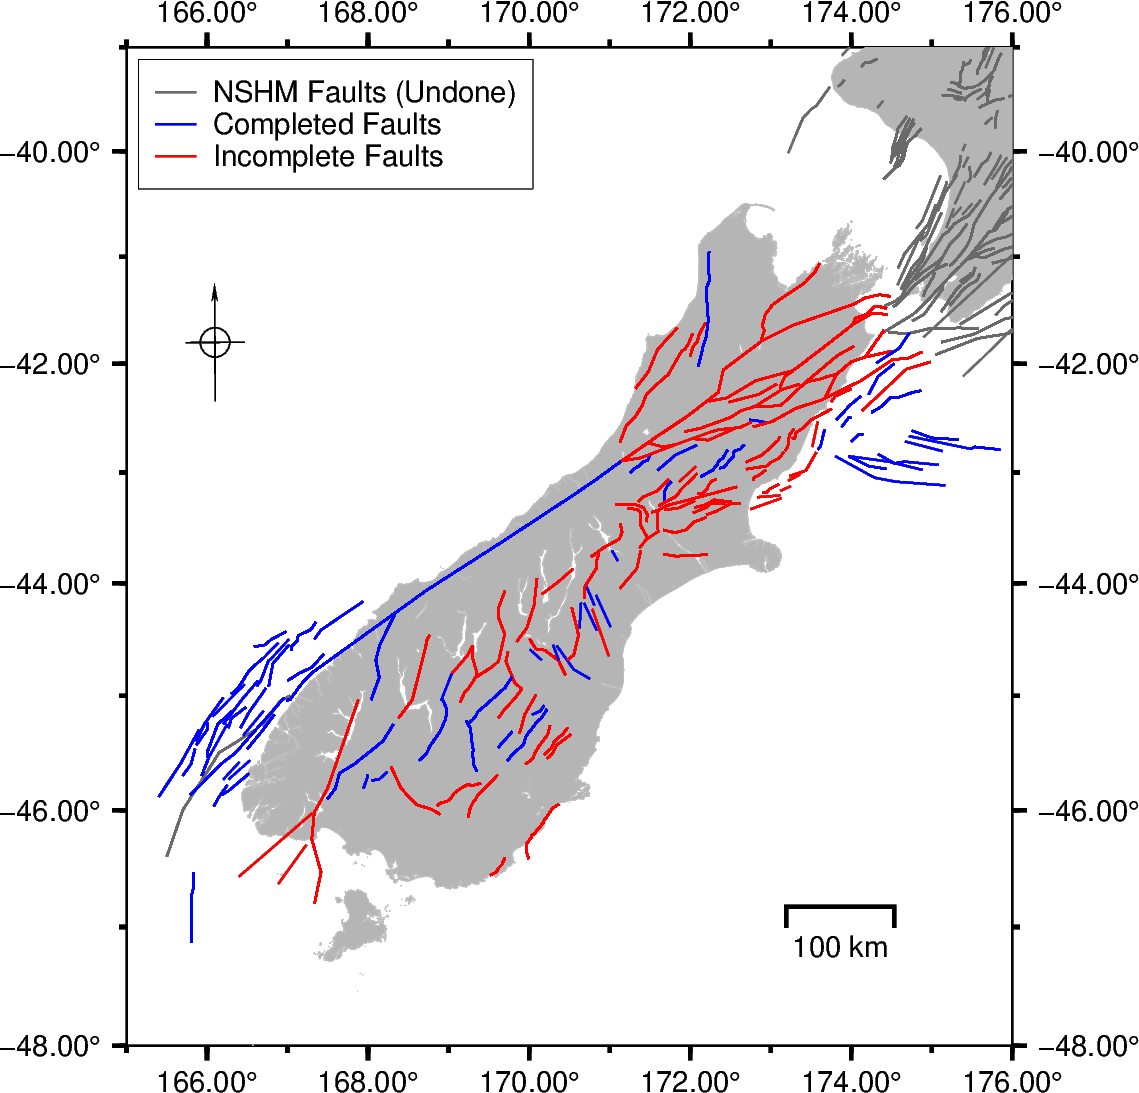

In [42]:
plot_using_mapdata = False

if plot_using_mapdata == True:
    # loading the mapdata
    map_data = (
        plotting.NZMapData.load(map_data_ffp) if map_data_ffp is not None else None
    )
else:
    map_data = None

fig = gen_region_fig(
    title=None,
    region=[165, 176, -48, -39],
    projection="M7.5c",
    map_data=map_data,
    plot_topo=True,
    plot_roads=False,
    plot_highways=False,
    plot_kwargs={
        "highway_pen_width": 0.1,
        "coastline_pen_width": 0.001,
        "topo_cmap": "gray",  # etopo1 geo
        "topo_cmap_min": 0,
        "topo_cmap_max": 3700,
        "topo_cmap_inc": 250,
        "topo_cmap_reverse": True,
    },
    config_options=dict(
        MAP_FRAME_TYPE="graph",
        FORMAT_GEO_MAP="ddd.xx",
        MAP_GRID_PEN="0.5p,gray",
        MAP_TICK_PEN_PRIMARY="1p,black",
        MAP_FRAME_PEN="thinner,black",
        MAP_FRAME_AXES="WSEN",
        FONT_ANNOT_PRIMARY="7p,Helvetica,black",
        FONT_LABEL="7p",  # Font size for axis labels
        FONT_TITLE="9p",  # Font size for the title
    ),
)
fig.basemap(map_scale="jBR+w100k+o1c/1c", rose="JTL+w1.0c+o0.5c/2c")

for fault_name in list_faults_all:
    fault_object = sha.nshm_2010.get_fault_objects(flt_erf[fault_name])
    for i in range(len(fault_object.planes)):
        ##create a shapely geometry for the plane
        ##(see https://github.com/ucgmsim/source_modelling/blob/ecf02f6d5d2fee4e8b8c5e9a1c3449a2d84789ec/source_modelling/sources.py#L403 )
        subfault_polygon = fault_object.planes[i].geometry
        # lats, lons, depth = zip(*[coords.nztm_to_wgs_depth(np.array(coord)) for coord in subfault_polygon.exterior.coords])
        
        long_trace, lat_trace = zip(*flt_erf[fault_name].trace.tolist())
        fig.plot(x=long_trace, y=lat_trace, pen="0.5p,dimgray")
    

for fault_name in FV.index:
    
    fault_object = sha.nshm_2010.get_fault_objects(flt_erf[fault_name])
    for i in range(len(fault_object.planes)):
        ##create a shapely geometry for the plane
        ##(see https://github.com/ucgmsim/source_modelling/blob/ecf02f6d5d2fee4e8b8c5e9a1c3449a2d84789ec/source_modelling/sources.py#L403 )
        subfault_polygon = fault_object.planes[i].geometry
        # lats, lons, depth = zip(*[coords.nztm_to_wgs_depth(np.array(coord)) for coord in subfault_polygon.exterior.coords])
        long_trace, lat_trace = zip(*flt_erf[fault_name].trace.tolist())
        if FV.loc[fault_name, "realization_tag"] == "undone":
            continue
        elif FV.loc[fault_name, "realization_tag"] == "good":
            fig.plot(x=long_trace, y=lat_trace, pen="0.5p,blue")
        elif FV.loc[fault_name, "realization_tag"] == "mixed":
            fig.plot(x=long_trace, y=lat_trace, pen="0.5p,blue")
        elif FV.loc[fault_name, "realization_tag"] == "incomplete":
            fig.plot(x=long_trace, y=lat_trace, pen="0.5p,red")


    
## Creating a sythetic legend:)
fig.plot(x=[190, 200], y=[-40, -40], pen="0.5p,dimgray", label="NSHM Faults (Undone)")
fig.plot(x=[190, 200], y=[-40, -40], pen="0.5p,blue", label="Completed Faults")
fig.plot(x=[190, 200], y=[-40, -40], pen="0.5p,red", label="Incomplete Faults")


fig.legend(position="JTL+o0.1c/-1.2c+jBL", box="+gwhite+p0.1p,black")

fig.show()

fig.savefig(plot_dir / 'old_run_fault_trace.png', dpi=900)

# Determine the Origin of Combined Realizations

In [43]:
file_name = "combination_logs.txt"
with open (combined_sim_dir / file_name, "r") as f:
    version_control_list = [line for line in f if line.startswith('Note(Version_Control):')]



version_control_df = pd.DataFrame(columns=['origin_version', 'fault_name', 'origin_rel_num', 'dest_rel_num'])

for item in version_control_list:
    origin_version = item.split("/")[0].split(": ")[1].strip()
    fault_name = item.split("/")[1].split("_")[0]
    origin_rel_num = item.split("/")[1].split("_")[1].split('-->')[0].strip()
    dest_rel_num = item.split("/")[1].split("_")[-1].split(".")[0]

    version_control_df.loc[len(version_control_df)] = [
        origin_version, fault_name, origin_rel_num, dest_rel_num
    ]

version_control_df.set_index((['origin_version', 'fault_name']), inplace=True)
version_control_df = version_control_df.sort_index(level=[0, 1])


# Introduce Topography Representation Type 

In [44]:
data = {
    "version": ['v21p6', 'v21p6p2', 'v22p2', 'v22p4', 'v23p5', 'v23p7', 'v23p10'],
    "topo_type": ['bld', 'bld', 'bld', 'bld', 'bld', 'bld', 'sqt'] # sqr = squshed-tapred, bld = bulldozed
}
version_topo_type = pd.DataFrame(data)
version_topo_type.set_index('version', inplace=True)
version_topo_type

,topo_type
version,
v21p6,bld
v21p6p2,bld
v22p2,bld
v22p4,bld
v23p5,bld
v23p7,bld
v23p10,sqt


# Identify Target Faults

In [45]:
# Identify faults with bld topo type
bld_versions = list(version_topo_type[version_topo_type['topo_type']=="bld"].index)
bld_faults = {ver: None for ver in bld_versions}
for item in list(version_topo_type[version_topo_type['topo_type']=="bld"].index):
    bld_faults[item] = list(FV[~FV[item].isna()].index)

# Identify faults with sqt topo type
sqt_versions = list(version_topo_type[version_topo_type['topo_type']=="sqt"].index)
sqt_faults = {ver: None for ver in sqt_versions}
for item in list(version_topo_type[version_topo_type['topo_type']=="sqt"].index):
    sqt_faults[item] = list(FV[~FV[item].isna()].index)

# Convert dict values to sets of faults
bld_faults_set = set().union(*bld_faults.values())
sqt_faults_set = set().union(*sqt_faults.values())

# Identify faults that are shared between bld and sqt topo types
shared_faults = sorted(bld_faults_set & sqt_faults_set)

# Identify faults that are only in bld topo type
bld_only_faults = sorted(bld_faults_set - sqt_faults_set)


In [46]:
print(f"Number of faults with Bulldozed topo type: {len(bld_faults_set)}")
print(f"Number of shared faults between Bulldozed and Squashed-Tapered topo types: {len(shared_faults)}")
print(f"Number of faults only in Bulldozed topo type: {len(bld_only_faults)}")
print("List of Bulldozed-only faults:")
for fault in bld_only_faults:
    print(f" - {fault}")

Number of faults with Bulldozed topo type: 141
Number of shared faults between Bulldozed and Squashed-Tapered topo types: 3
Number of faults only in Bulldozed topo type: 138
List of Bulldozed-only faults:
 - AhuririR
 - Akatore
 - Albury
 - AlpineF2K
 - AlpineR
 - Ashley
 - Barefell
 - Billys
 - BlueLk
 - BlueMtn
 - Brothers
 - Browning
 - BrunAnt
 - CBalleny
 - CardronaN
 - CardronaS
 - Caswell1
 - Caswell211
 - Caswell3
 - Caswell4
 - Caswell5
 - CaswellH10
 - CaswellH67
 - CaswellH8
 - CaswellH9
 - Chalky1to3
 - Chalky4to8
 - Cheeseman
 - ClarenceCentr
 - Cust
 - Cw4Swedge411
 - Cwedge123
 - Dalgety
 - DoubleHill
 - Dryburgh
 - Dunstan
 - Esk
 - FernGully
 - Fidget
 - FiordMar1-2
 - FiveFingers
 - Fowlers
 - FoxPk
 - GeorgeR1
 - Gimmerburn
 - Grandview
 - Hanmer
 - Harper
 - Hauroko
 - Hokonui
 - Hollyford
 - HopeConwayOS
 - Hororata
 - HumpR
 - Hunter
 - HuttPeelNorth
 - HuttPeelSouth
 - Hyde
 - Inangahua
 - IrishmanC
 - KaiwaraN
 - KaiwaraS
 - Kelly
 - Kirkliston
 - LeesV
 - Lindi

# Create Target Faults Datebase

In [47]:
tg_faults = shared_faults

db_tg_faults = {fault: {'stations': None, 'bld_ims': None, 'sqt_ims': None}
                for fault in tg_faults}

# Load bld ims
for ver, faults in bld_faults.items():
    for fault in faults:
        if fault not in shared_faults:
            continue

        if (ver, fault) in version_control_df.index:
            dest_rels = version_control_df.loc[(ver, fault), 'dest_rel_num']
        else:
            print(f"({ver}, {fault}) not found")
        
        if isinstance(dest_rels, (pd.Series, pd.Index)):
            rels = dest_rels.tolist()
        elif isinstance(dest_rels, (list, tuple)):
            rels = list(dest_rels)
        else:
            rels = [dest_rels]

        frames = []
        kept_rels = []
        for rel in rels:
            path = combined_sim_dir / fault / 'IM' / f"{fault}_{rel}.csv"
            df = pd.read_csv(path, index_col=0)
            df.drop(columns=['component'], inplace=True)
            frames.append(df)
            kept_rels.append(rel)

        if not frames:
            continue

        stations = frames[0].index
        ims = frames[0].columns
        arr = np.stack([f.loc[stations, ims].to_numpy() for f in frames], axis=0)

        da = xr.DataArray(
            arr,
            dims=("realization", "station", "im"),
            coords={"realization": kept_rels, "station": stations, "im": ims},
            name="IM",
        )

        db_tg_faults[fault]['bld_ims'] = da
        db_tg_faults[fault]['stations'] = stations.tolist()
        

# load sqt results

for ver, faults in sqt_faults.items():
    for fault in faults:
        if fault not in shared_faults:
            continue

        if (ver, fault) in version_control_df.index:
            dest_rels = version_control_df.loc[(ver, fault), 'dest_rel_num']
        else:
            print(f"({ver}, {fault}) not found") # I wrote this control becuse we have a empty folders of 'CardronaS' and 'Ranfurly' in v21p6p2
        
        if isinstance(dest_rels, (pd.Series, pd.Index)):
            rels = dest_rels.tolist()
        elif isinstance(dest_rels, (list, tuple)):
            rels = list(dest_rels)
        else:
            rels = [dest_rels]

        frames = []
        kept_rels = []
        for rel in rels:
            path = combined_sim_dir / fault / 'IM' / f"{fault}_{rel}.csv"
            df = pd.read_csv(path, index_col=0)
            df.drop(columns=['component'], inplace=True)
            frames.append(df)
            kept_rels.append(rel)

        if not frames:
            continue

        stations = frames[0].index
        ims = frames[0].columns
        arr = np.stack([f.loc[stations, ims].to_numpy() for f in frames], axis=0)

        da = xr.DataArray(
            arr,
            dims=("realization", "station", "im"),
            coords={"realization": kept_rels, "station": stations, "im": ims},
            name="IM",
        )

        db_tg_faults[fault]['sqt_ims'] = da

In [48]:
print(f"{db_tg_faults[next(iter(db_tg_faults))]['bld_ims'].coords}")
print(f"{db_tg_faults[next(iter(db_tg_faults))]['bld_ims'].dims}")

Coordinates:
  * realization  (realization) <U5 660B 'REL01' 'REL02' ... 'REL32' 'REL33'
  * station      (station) object 44kB '0200003' '0200008' ... 'WNPS' 'WSFC'
  * im           (im) object 304B 'PGA' 'PGV' 'CAV' ... 'pSA_7.5' 'pSA_10.0'
('realization', 'station', 'im')


In [49]:
da_pga = db_tg_faults[next(iter(db_tg_faults))]['bld_ims'].sel(im="PGA")
q = da_pga.quantile(xr.DataArray([0.50, 0.84], dims="quantile"),
                    dim="realization", skipna=True)
q.to_pandas().T

quantile,0.50,0.84
station,,
0200003,0.003298,0.005712
0200008,0.004174,0.007143
0200009,0.003752,0.006830
020000a,0.003673,0.006375
0200010,0.004062,0.006529
...,...,...
WHFS,0.006652,0.008495
WHZ,0.010291,0.015714
WKZ,0.026768,0.032341


# Define Interested IMs and Percentiles

In [58]:
IMS = [
    'pSA_0.01',
    'pSA_0.5',
    'pSA_5.0',
]


PER =[
    0.16,
    0.5,
    0.84,
]

# Prepare Data

## Select Data

In [59]:
sel_data_dic = {fault: {im: None for im in IMS} for fault in shared_faults}

for fault in shared_faults:
    sel_data = stations_df[stations_df['station_name'].isin(db_tg_faults[fault]['stations'])].copy()
    sel_data = sel_data.drop(columns=['sigma'])
    sel_data.set_index('station_name', inplace=True)
    sel_data = sel_data.astype(float)
    for im in IMS:
        # add bld  data
        bld_im_values = db_tg_faults[fault]['bld_ims'].sel(im=im)
        q = bld_im_values.quantile(xr.DataArray(PER, dims="quantile"), dim="realization", skipna=False)
        q_df = q.transpose("station", "quantile").to_pandas()
        # Rename columns using quantile values as strings
        q_df.columns = [f"bld_per_{str(p)}_{im}" for p in q_df.columns]
        sel_data = sel_data.join(q_df, how="left")
        
        # add sqt data
        sqt_im_values = db_tg_faults[fault]['sqt_ims'].sel(im=im)
        q = sqt_im_values.quantile(xr.DataArray(PER, dims="quantile"), dim="realization", skipna=False)
        q_df = q.transpose("station", "quantile").to_pandas()
        q_df.columns = [f"sqt_per_{str(p)}_{im}" for p in q_df.columns]
        sel_data = sel_data.join(q_df, how="left")
        
        # compute and add diff data
        for p in PER:
            sel_data[f"ln_bld_over_sqt_{p}_{im}"] = np.log(sel_data[f"bld_per_{p}_{im}"] / sel_data[f"sqt_per_{p}_{im}"])
        
        sel_data_dic[fault][im] = sel_data
            
            

## Create Grid

In [ ]:
im_grid_dic = {fault: {im: {str(p): {'bld': None, 'sqt': None, 'diff': None} for p in PER} for im in IMS} for fault in shared_faults}

for fault in shared_faults:
    for im in IMS:
        data_df = sel_data_dic[fault][im]
        data_df = data_df.rename(columns={'long': 'lon'})
        for p in PER:
            # bld
            bld_grid = create_grid(
                data_df= data_df,
                data_key= f"bld_per_{p}_{im}",
                grid_spacing = "200e/200e",
                region= [min(data_df['lon']), max(data_df['lon']), min(data_df['lat']), max(data_df['lat'])],  # lon_min, lon_max, lat_min, lat_max
                interp_method= "linear",
                set_water_to_nan= True,
                )
            im_grid_dic[fault][im][str(p)]['bld'] = bld_grid
            
            # sqt
            sqt_grid = create_grid(
                data_df= data_df,
                data_key= f"sqt_per_{p}_{im}",
                grid_spacing = "200e/200e",
                region= [min(data_df['lon']), max(data_df['lon']), min(data_df['lat']), max(data_df['lat'])],  # lon_min, lon_max, lat_min, lat_max
                interp_method= "linear",
                set_water_to_nan= True,
                )
            im_grid_dic[fault][im][str(p)]['sqt'] = sqt_grid
            
            # diff
            diff_grid = create_grid(
                data_df= data_df,
                data_key= f"ln_bld_over_sqt_{p}_{im}",
                grid_spacing = "200e/200e",
                region= [min(data_df['lon']), max(data_df['lon']), min(data_df['lat']), max(data_df['lat'])],  # lon_min, lon_max, lat_min, lat_max
                interp_method= "linear",
                set_water_to_nan= True,
                )
            
            
            im_grid_dic[fault][im][str(p)]['diff'] = diff_grid

# Plot Maps

In [ ]:

import colorcet as cc

with tempfile.TemporaryDirectory() as tmp_dir:
        tmp_dir = Path(tmp_dir)
        
        
        
        # Step 1: Pick a colormap and sample 256 RGB values
        cmap = cc.cm['CET_D1A']  # Any ColorCET colormap (reversed here as example)
        rgb_array = (np.array([cmap(i / 255)[:3] for i in range(256)]) * 255).astype(int)

        # Step 2: Define levels from -0.9 to 0.9 in 0.2 steps
        levels = np.round(np.arange(-0.2, 0.21, 0.02), 3)
        normed = ((levels - levels.min()) / (levels.max() - levels.min()) * 255).astype(int)
        normed = ((0.75* (normed - 127)) + 127).astype(int)  # Adjust to center around 127
        colors = rgb_array[normed]

        # Step 3: Set the center bin (-0.1 to 0.1) to white
        for i in range(len(levels) - 1):
            if levels[i] >= -0.025 and levels[i + 1] <= 0.02:
                colors[i] = [255, 255, 255]
                colors[i + 1] = [255, 255, 255]

        # Step 4: Write to CPT file
        with open(tmp_dir /"custom_bmw_white_center.cpt", "w") as f:
            for i in range(len(levels) - 1):
                val1 = levels[i]
                val2 = levels[i + 1]
                r1, g1, b1 = colors[i]
                r2, g2, b2 = colors[i + 1]
                f.write(f"{val1:.2f} {r1} {g1} {b1} {val2:.2f} {r2} {g2} {b2}\n")
            f.write("B 255 255 255\n")
            f.write("F 0 0 0\n")
            f.write("N 128 128 128\n")

        cmap_custom = "custom_bmw_white_center.cpt"

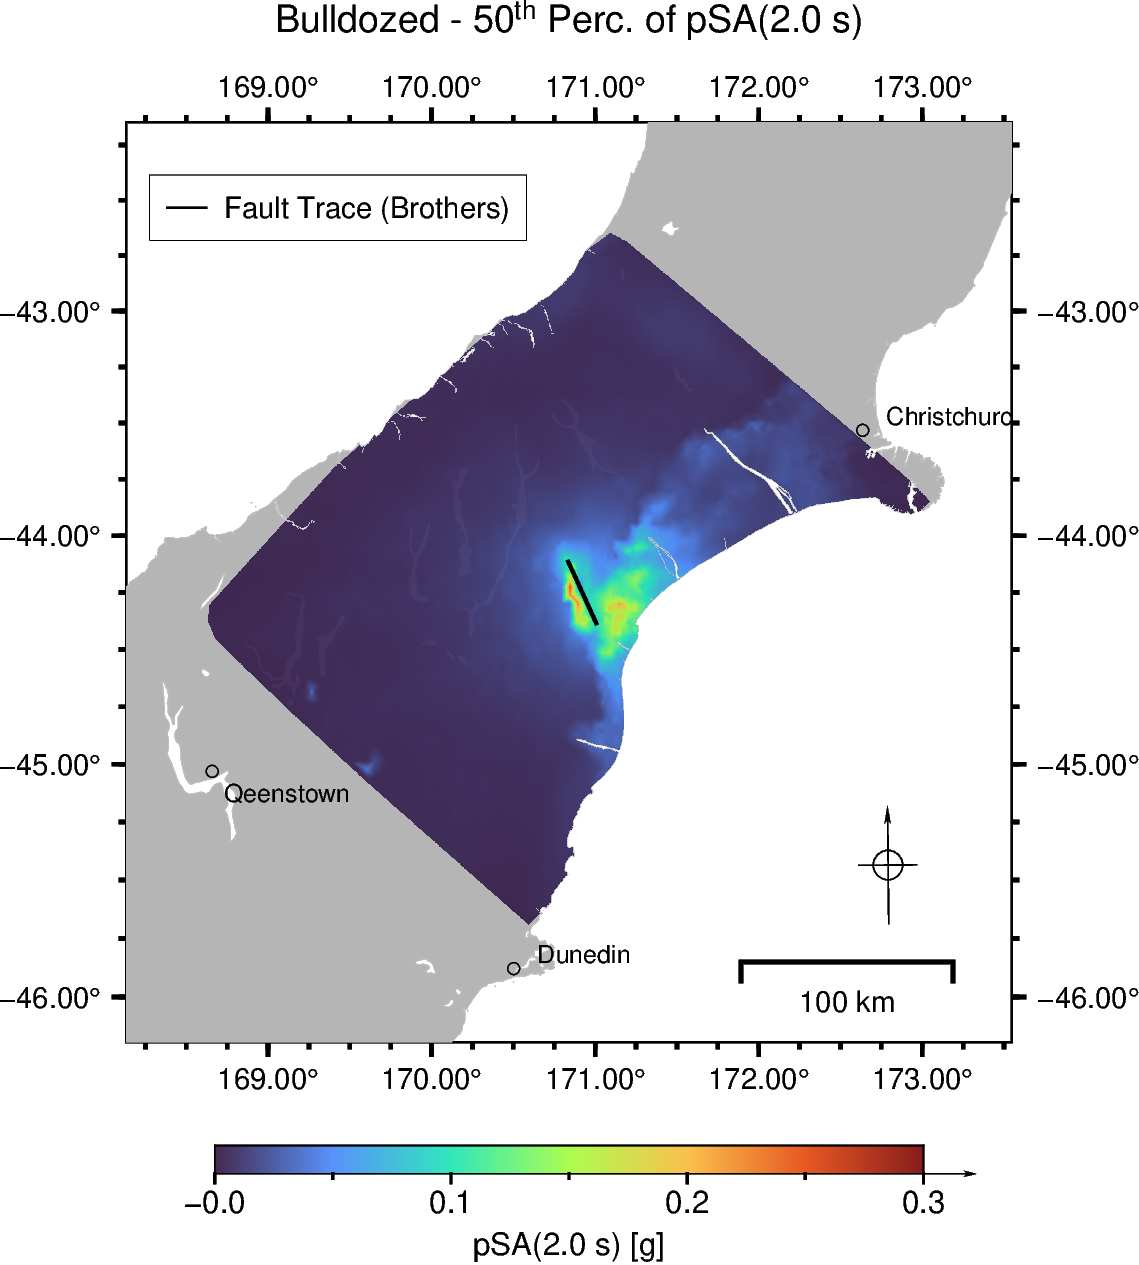

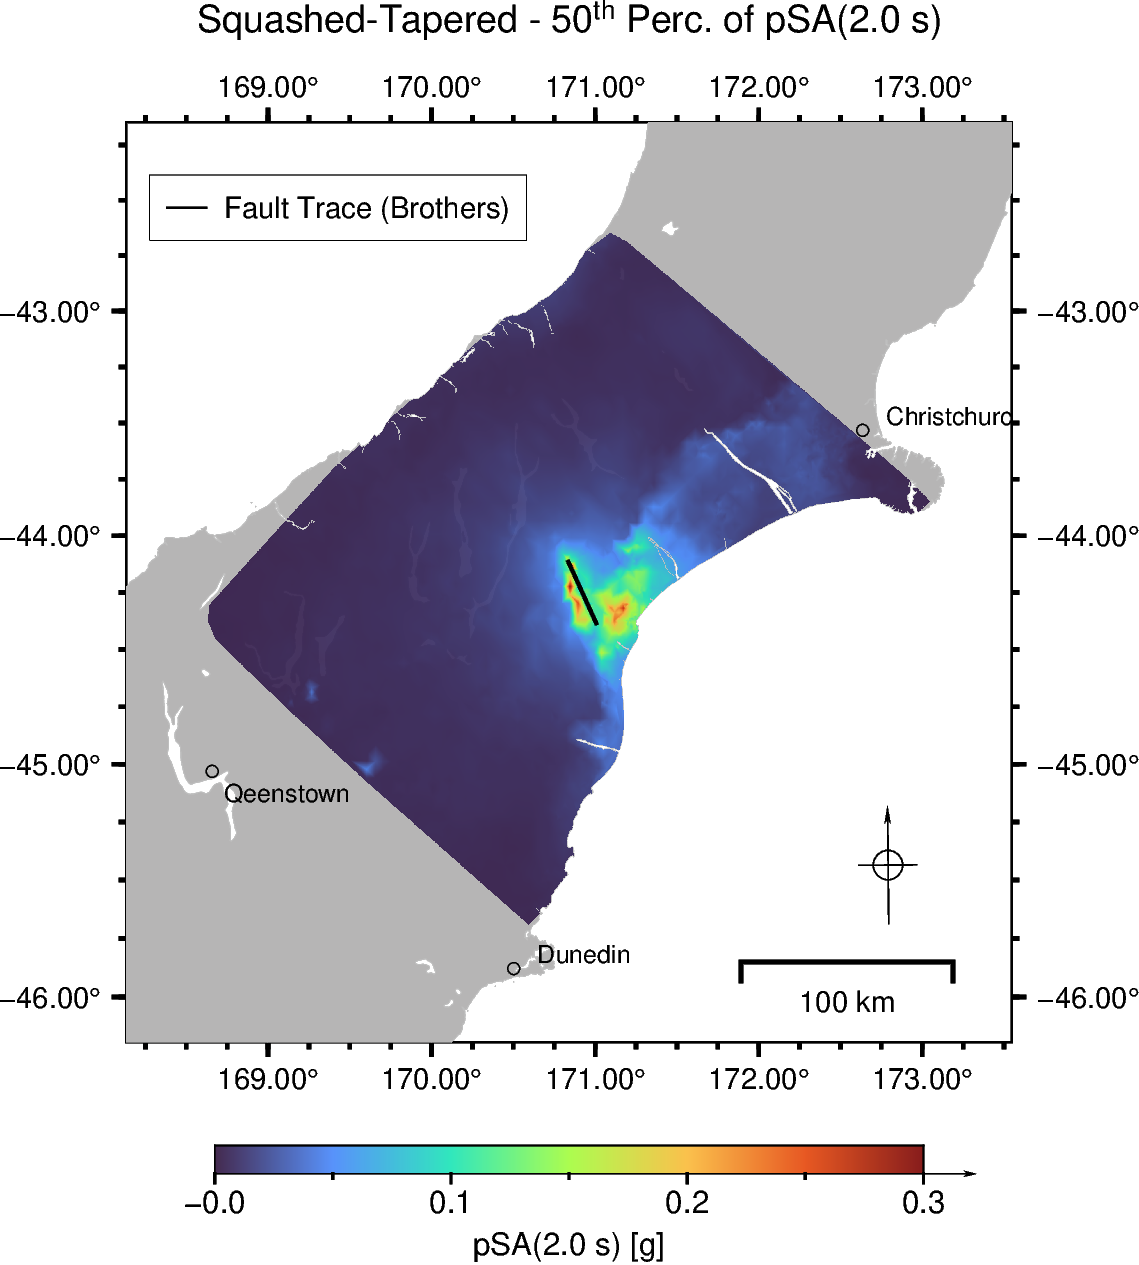

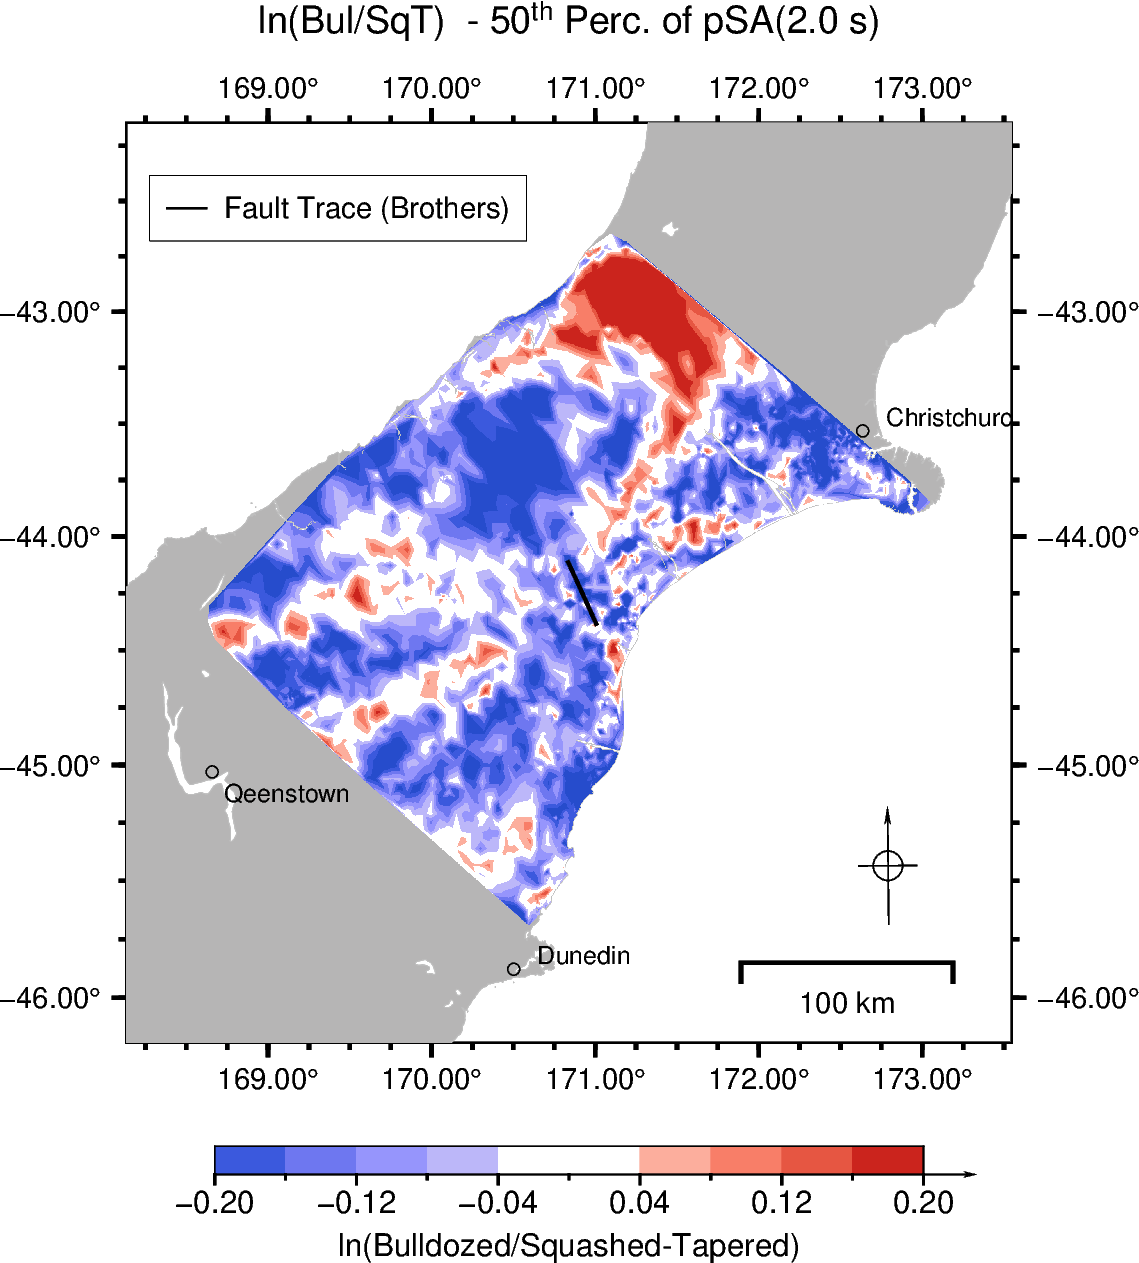

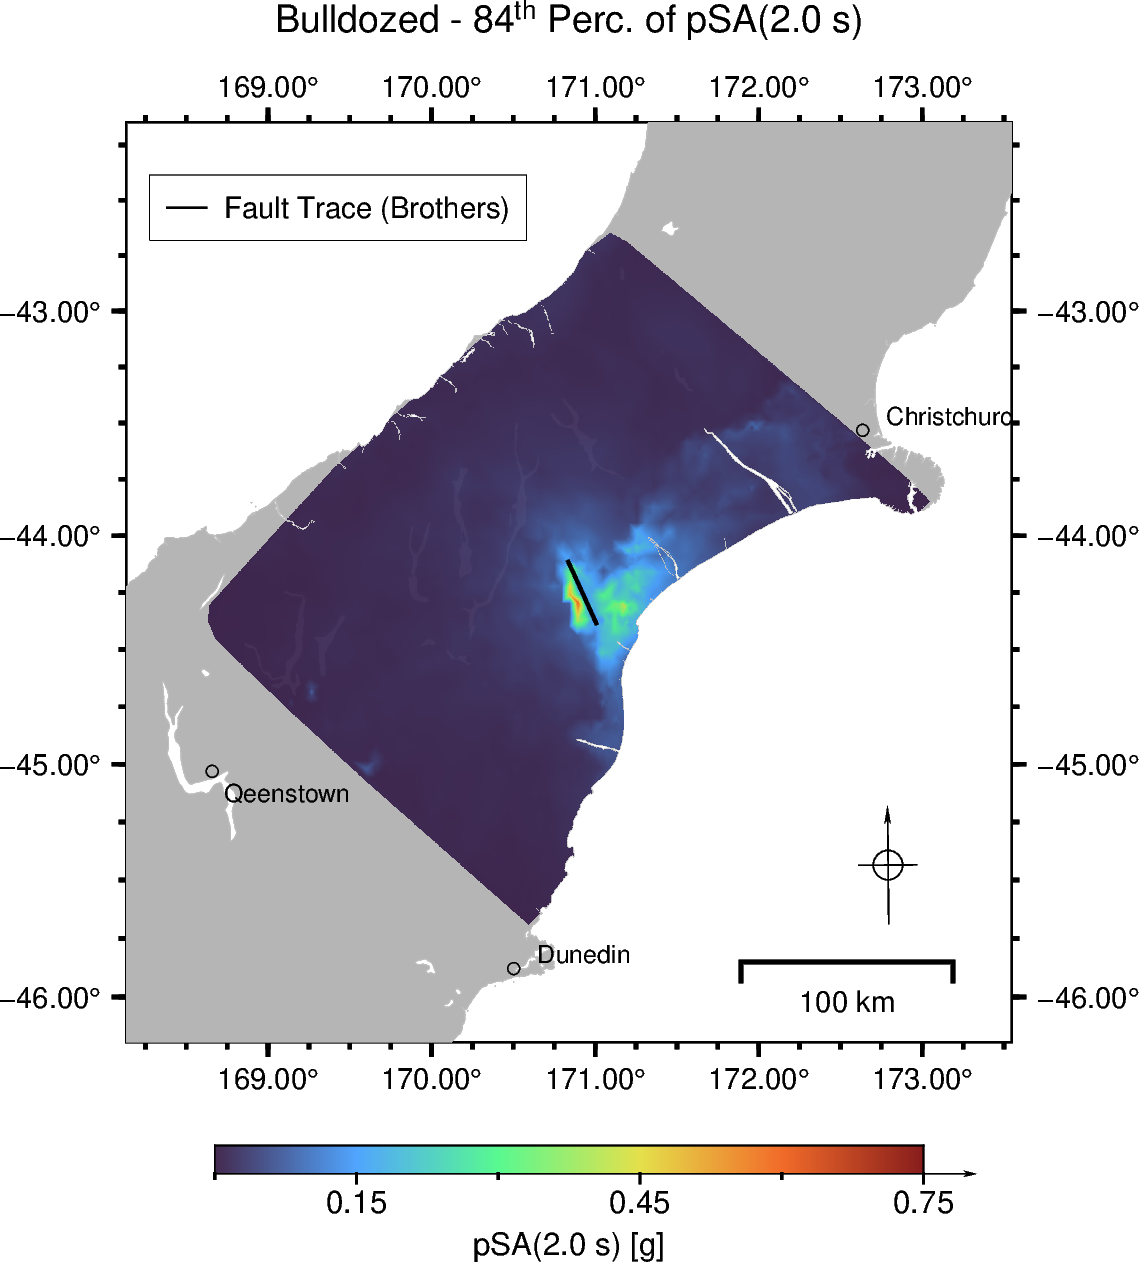

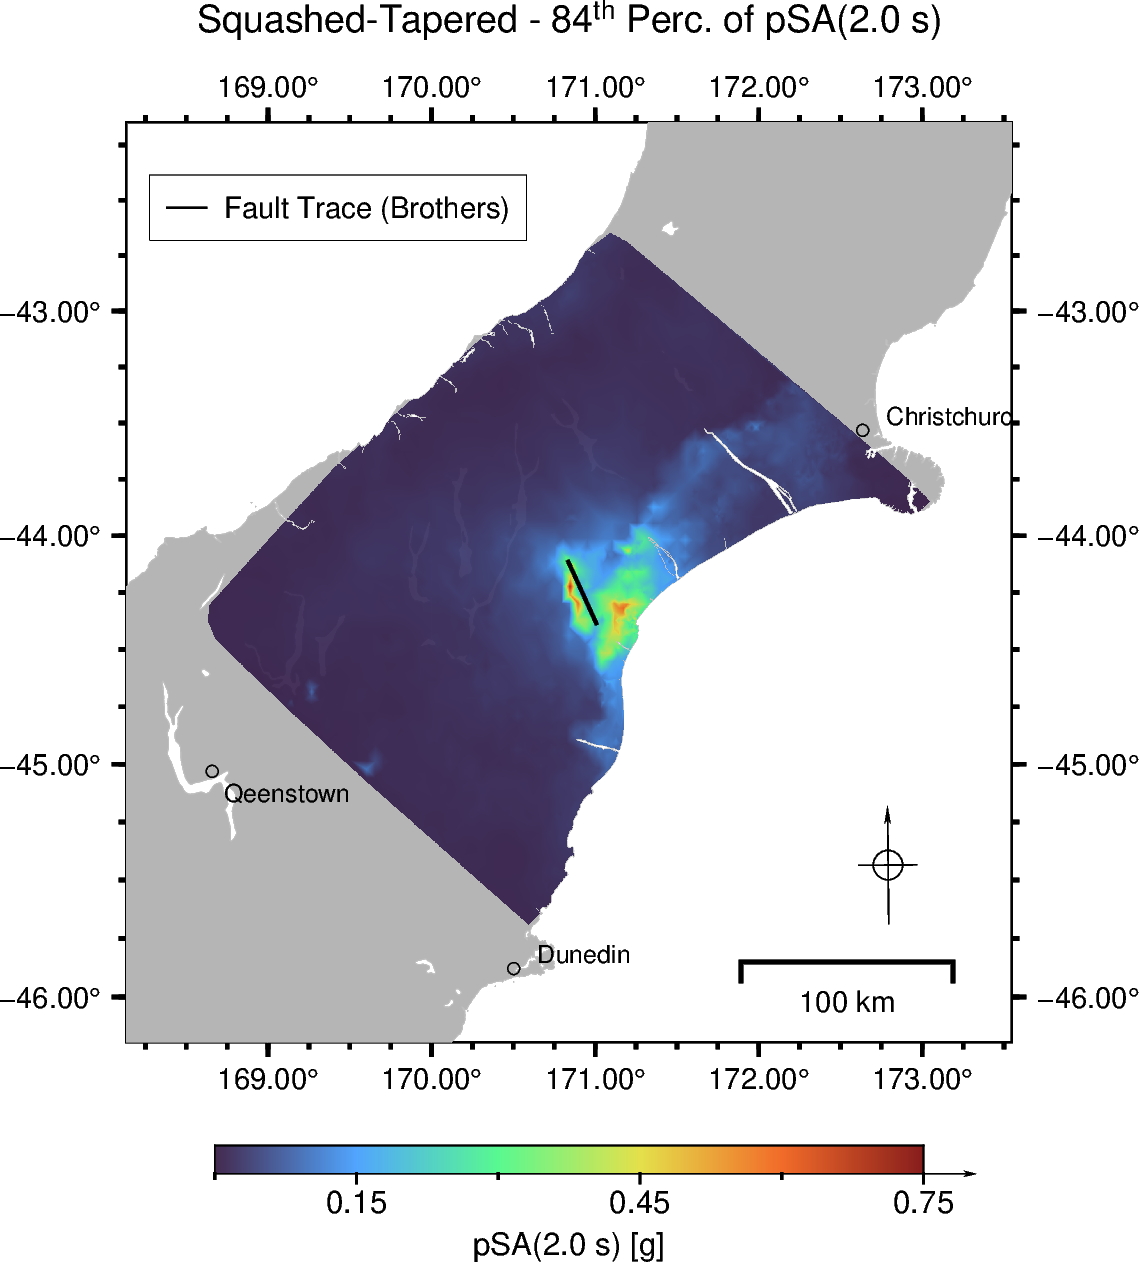

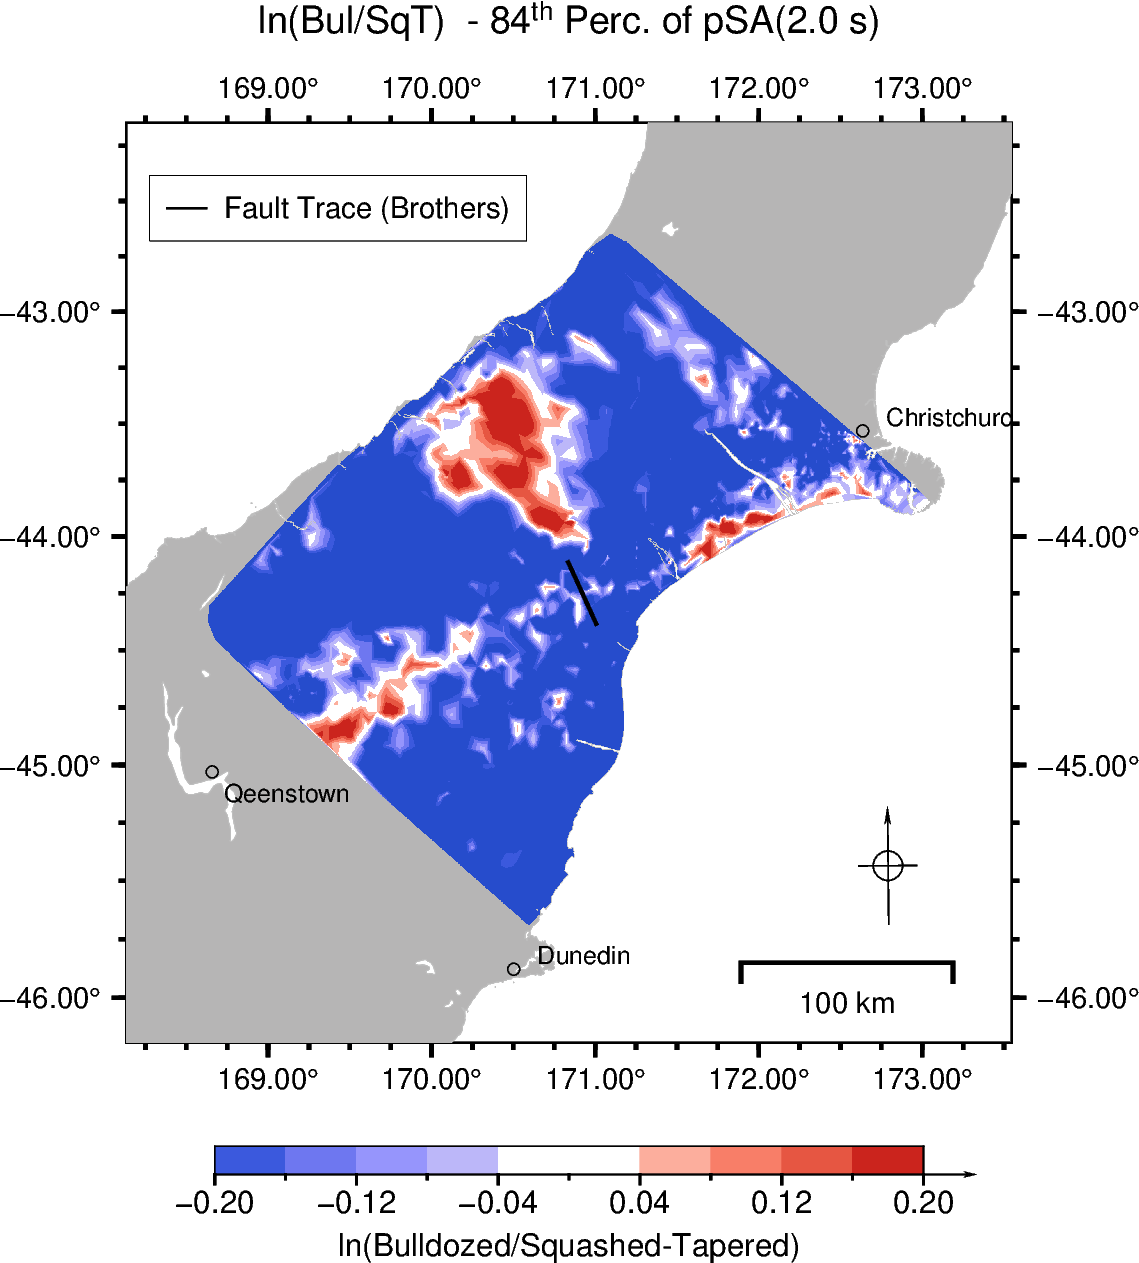

In [ ]:
plot_using_mapdata = False

if plot_using_mapdata == True:
    # loading the mapdata
    map_data = (
        plotting.NZMapData.load(map_data_ffp) if map_data_ffp is not None else None
    )
else:
    map_data = None

topo_type = ["bld", "sqt", "diff"]

for fault in shared_faults:
    for im in IMS:
        for p in PER:
            for t_type in topo_type:
                grid = im_grid_dic[fault][im][str(p)][t_type]
                if t_type == "diff":
                    vmin_n, vmax_n, step, _ = nice_colorbar_limits(
                        im_grid_dic[fault][im][str(p)]["diff"].min().to_numpy(),
                        im_grid_dic[fault][im][str(p)]["diff"].max().to_numpy(),
                        symmetric=True,
                    )
                    cmap_limits = [vmin_n, vmax_n, step]
                    cmap_limits = [-0.2, 0.2, 0.04]
                    cmap = cmap_custom  # cmap_custom
                else:
                    vmin_n, vmax_n, step, _ = nice_colorbar_limits(
                        0,
                        max(
                            im_grid_dic[fault][im][str(p)]["bld"].max().to_numpy(),
                            im_grid_dic[fault][im][str(p)]["sqt"].max().to_numpy(),
                        ),
                        symmetric=False,
                    )
                    cmap_limits = [vmin_n, vmax_n, step]
                    cmap = "turbo"  # roma thermal curl rainbow

                # Construct the title string here
                if t_type == "bld":
                    topo_string = "Bulldozed"
                elif t_type == "sqt":
                    topo_string = "Squashed-Tapered"
                elif t_type == "diff":
                    topo_string = "ln(Bul/SqT) "

                title_string = f"{topo_string} - {int(p*100)}@+th@+ Perc. of {convert_im(im).split('[')[0]}"

                # Define the map plot region
                region = [166.2, 174.5, -47.4, -40.2]  # south island region
                region = [
                    grid.lon.min().item() - 0.5,
                    grid.lon.max().item() + 0.5,
                    grid.lat.min().item() - 0.5,
                    grid.lat.max().item() + 0.5,
                ]

                fig = gen_region_fig(
                    title=title_string,
                    region=region,
                    projection="M7.5c",
                    map_data=map_data,
                    plot_topo=True,
                    plot_roads=False,
                    plot_highways=False,
                    plot_kwargs={
                        "highway_pen_width": 0.1,
                        "coastline_pen_width": 0.01,
                        "topo_cmap": "gray",  # etopo1 geo
                        "topo_cmap_min": 0,
                        "topo_cmap_max": 3700,
                        "topo_cmap_inc": 250,
                        "topo_cmap_reverse": True,
                        # "frame_args": frame_settings,
                    },
                    config_options=dict(
                        MAP_FRAME_TYPE="graph",
                        FORMAT_GEO_MAP="ddd.xx",
                        MAP_GRID_PEN="0.5p,gray",
                        MAP_TICK_PEN_PRIMARY="1p,black",
                        MAP_FRAME_PEN="thinner,black",
                        MAP_FRAME_AXES="WSEN",
                        FONT_ANNOT_PRIMARY="7p,Helvetica,black",
                        FONT_LABEL="7p",  # Font size for axis labels
                        FONT_TITLE="9p,Helvetica,black",  # Font size for the title
                    ),
                    # frame=frame_settings,
                )

                fig.basemap(
                    map_scale="jBR+w100k+o0.5c/0.5c", rose="JBR+w1.0c+o0.8c/1.0c"
                )

                plot_grid(
                    fig=fig,
                    grid=grid,
                    cmap=cmap,
                    cmap_limits=cmap_limits,
                    # cmap_limit_colors=("white", "white"), # not used in this case which allows to use the cmap_limits
                    cb_label=(
                        "ln(Bulldozed/Squashed-Tapered)"
                        if t_type == "diff"
                        else convert_im(im)
                    ),  # Requires math mode support
                    reverse_cmap=False,
                    log_cmap=False,
                    transparency=(0 if t_type == "diff" else 10),
                    plot_contours=False,
                    continuous_cmap=(False if t_type == "diff" else True),
                )
                # Plot water
                if plot_using_mapdata:
                    fig.plot(data=map_data.water_df, fill="lightblue")

                # Plot Major Cities
                plot_major_cities = True

                # Plot Fault
                fault_object = sha.nshm_2010.get_fault_objects(flt_erf[fault])
                for i in range(len(fault_object.planes)):
                    long_trace, lat_trace = zip(*flt_erf[fault].trace.tolist())
                    fig.plot(x=long_trace, y=lat_trace, pen="0.9p,black")

                if plot_major_cities:
                    # Define city data
                    city_data = {
                        "City": [
                            "Auckland",
                            "Hamilton",
                            "Christchurch",
                            "Dunedin",
                            "Wellington",
                            "Tauranga",
                            "Whangarei",
                            "Qeenstown",
                        ],
                        "Latitude": [
                            -36.8485,
                            -37.7870,
                            -43.5321,
                            -45.8788,
                            -41.2865,
                            -37.6860,
                            -35.7251,
                            -45.0300,
                            
                        ],
                        "Longitude": [
                            174.7633,
                            175.2793,
                            172.6362,
                            170.5028,
                            174.7762,
                            176.1652,
                            174.3237,
                            168.6584,
                        ],
                        "Offset": [
                            "-1.0c/-0.2c",
                            "-1.0c/-0.1c",
                            "0.2c/0.2c",
                            "0.2c/0.2c",
                            "0.2c/-0.3c",
                            "0.1c/0.2c",
                            "0.2c/0.2c",
                            "0.1c/-0.1c",
                        ],
                    }

                    cities_df = pd.DataFrame(city_data)

                    fig.plot(
                        x=cities_df["Longitude"],
                        y=cities_df["Latitude"],
                        style="c0.1c",
                        # fill='black',
                        pen="black",
                    )

                    # Add city names
                    for i, row in cities_df.iterrows():
                        fig.text(
                            x=row["Longitude"],
                            y=row["Latitude"],
                            text=row["City"],
                            font="6p,Helvetica,black",
                            offset=row["Offset"],
                            justify="TL",
                        )

                    ## Creating a sythetic legend:)
                    fig.plot(
                        x=[190, 200],
                        y=[-40, -40],
                        pen="0.5p,black",
                        label=f"Fault Trace ({fault})",
                    )

                    fig.legend(
                        position="JTL+o0.2c/-1.0c+jBL", box="+gwhite+p0.1p,black"
                    )

                    fig.show()
                    fig.savefig(
                        Path(plot_dir) / f"{fault}_{im}_{p}_{t_type}.png",
                        dpi=900,
                        anti_alias=True,
                    )

In [ ]:
type(grid)

xarray.core.dataarray.DataArray